In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
%matplotlib inline
from histograms import fit_pedestal, make_histogram, subtract_pedestal
from file_utils import load_image
from matplotlib.colors import LogNorm
from hit_detection import get_hot_pixels

# Load an image
img = load_image("data/images/image8.npy")

# Fit and subtract the pedestal
pedestal_params, _ = fit_pedestal(*make_histogram(img, -1))
pedestal_subtracted = subtract_pedestal(img, pedestal_params)

pedestal_params

array([1.74633390e+05, 5.90883126e+01, 9.57892528e+00])

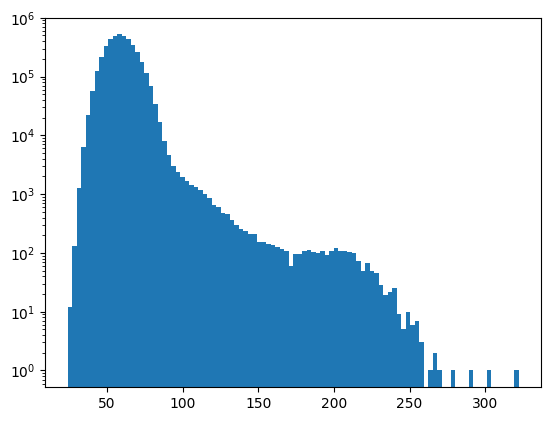

In [75]:
plt.hist(img.flatten(), bins=100)
plt.yscale("log")

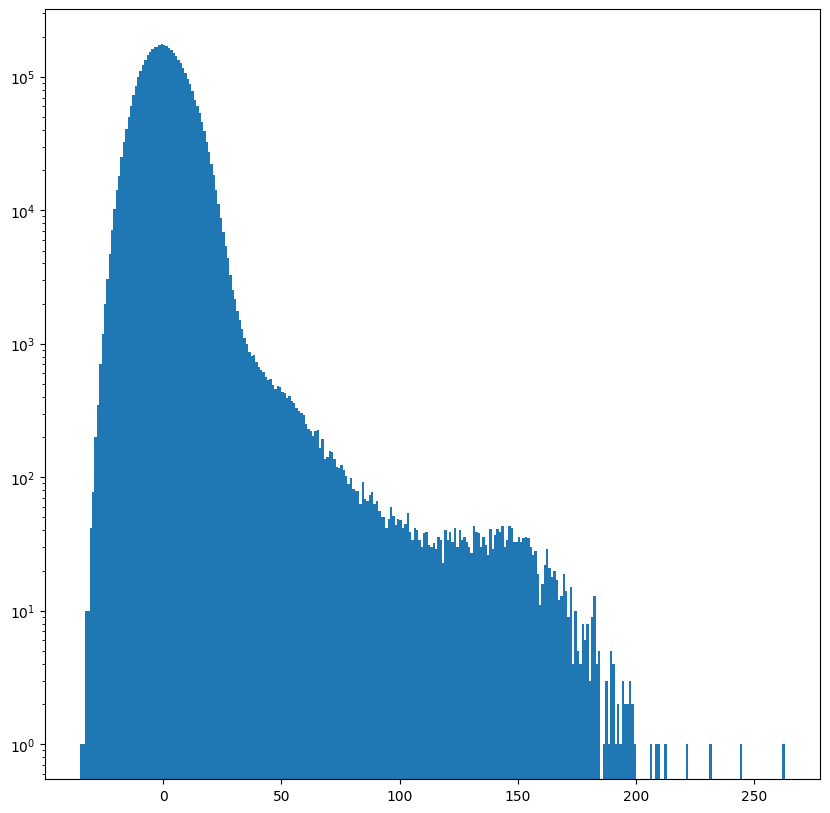

In [76]:
n_bins = -1
ps_bin_centres, ps_hist_data = make_histogram(pedestal_subtracted, n_bins)
plt.figure(figsize=(10, 10))
plt.bar(*make_histogram(pedestal_subtracted, n_bins), ps_bin_centres[1] - ps_bin_centres[0])
plt.yscale("log")


Let's try taking a histogram that does not include the spectral lines

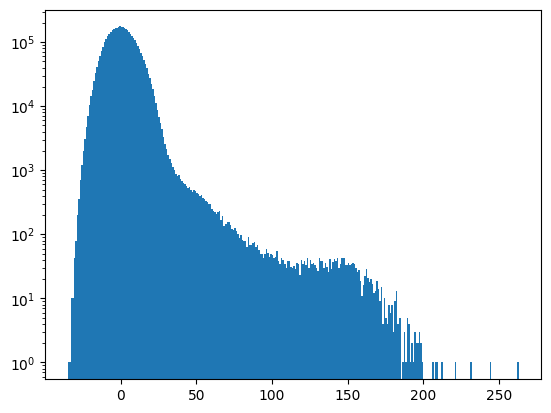

In [77]:
no_bragg_lines = pedestal_subtracted.copy()
no_bragg_lines = no_bragg_lines#[:, :1200]
n_bins = -1
nb_hist_centres, no_bragg_hist = make_histogram(no_bragg_lines, n_bins)

#plt.bar(nb_hist_centres, no_bragg_hist, nb_hist_centres[1] - nb_hist_centres[0])
plt.bar(nb_hist_centres, no_bragg_hist, nb_hist_centres[1] - nb_hist_centres[0])
plt.yscale("log")

# New single photon counting method

- Define a primary threshold. This is the threshold above which we are confident that a pixel has had a photon hit it. This should probably be just below the peak corresponding to the La/Lb line.

- We then define a second, lower threshold. Possible location could be just above end of noise peak. Pixels between this threshold and the higher one are likely to be due to charge spreading.
    - Both of these thresholds should probably be determined using parts of the image that are not in Bragg peaks, since SPC may not apply there.
    - TODO: does SPC apply in Bragg peaks? What does it mean for SPC to apply in terms of photon density.

- Initially only produce spectrum using primary. Will probably have shit uncertainty.

- Then work on including pixels below primary but above secondary. Considerations:
    - Could just take a 3x3 around each primary hit, and integrate over it (with signal removed). Danger: might have another photon hit in this region, so we end up integrating 2 hits. Maybe think about some Poisson statistics to quantify this probability.
    - Better way (I think?) is to look at each primary, and do bfs around it to get all secondaries. If there are too many, then that's a double hit. Finally, look at all secondary pixels that are not already integrated into another peak, and combine these clusters.


# Part 1: getting the primary threshold

Process:

- Get a histogram of the (noise-removed) data in an area that we do not expect to see any spectral lines

- There is a peak between 110 - 160, that is probably the one we are looking for from single photon hits. We can fit a Gaussian to this.

- We could then define the cutoff as $\mu-2\sigma$ since we should only miss ~2.1% of hits this way: $P(X<\mu-2\sigma) = 2.1\%$.

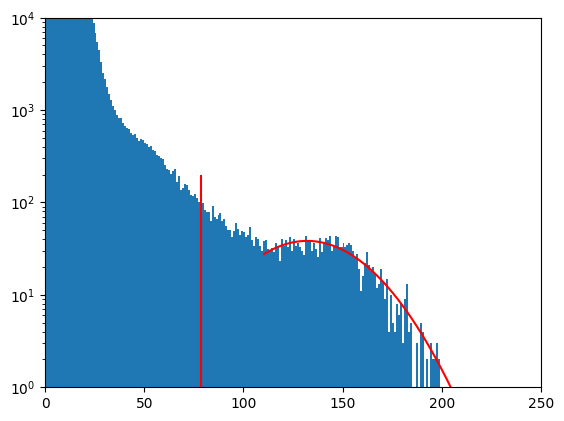

In [78]:
from histograms import gaussian_model
from scipy.optimize import curve_fit

search_indices = (nb_hist_centres > 110).nonzero()
xsearch_vals = nb_hist_centres[search_indices]
ysearch_vals = no_bragg_hist[search_indices]

popt, pcov = curve_fit(gaussian_model, xsearch_vals, ysearch_vals, p0=[30, 150, 10])

plt.bar(nb_hist_centres, no_bragg_hist, nb_hist_centres[1] - nb_hist_centres[0])
plt.plot(xsearch_vals, gaussian_model(xsearch_vals, *popt), color="red")
plt.xlim(0,250)
plt.yscale("log")
plt.ylim(1, 1e4)
popt, np.sqrt(np.diag(pcov))

primary_cutoff = popt[1] - 2 * popt[2]

plt.vlines(primary_cutoff, 0, 200, color="red")


## How many hits do we see?

In [79]:
len(pedestal_subtracted[pedestal_subtracted > primary_cutoff].flatten().nonzero()[0])

3799

## How many of these are single hits?

Ideally, the majority of these hits correspond to only one photon

In [80]:
from hit_detection import locate_hits

primary_hits = np.where(pedestal_subtracted >= primary_cutoff, pedestal_subtracted, 0)

hits = locate_hits(primary_hits)

len(hits)

3766

Image with only single photon hits:

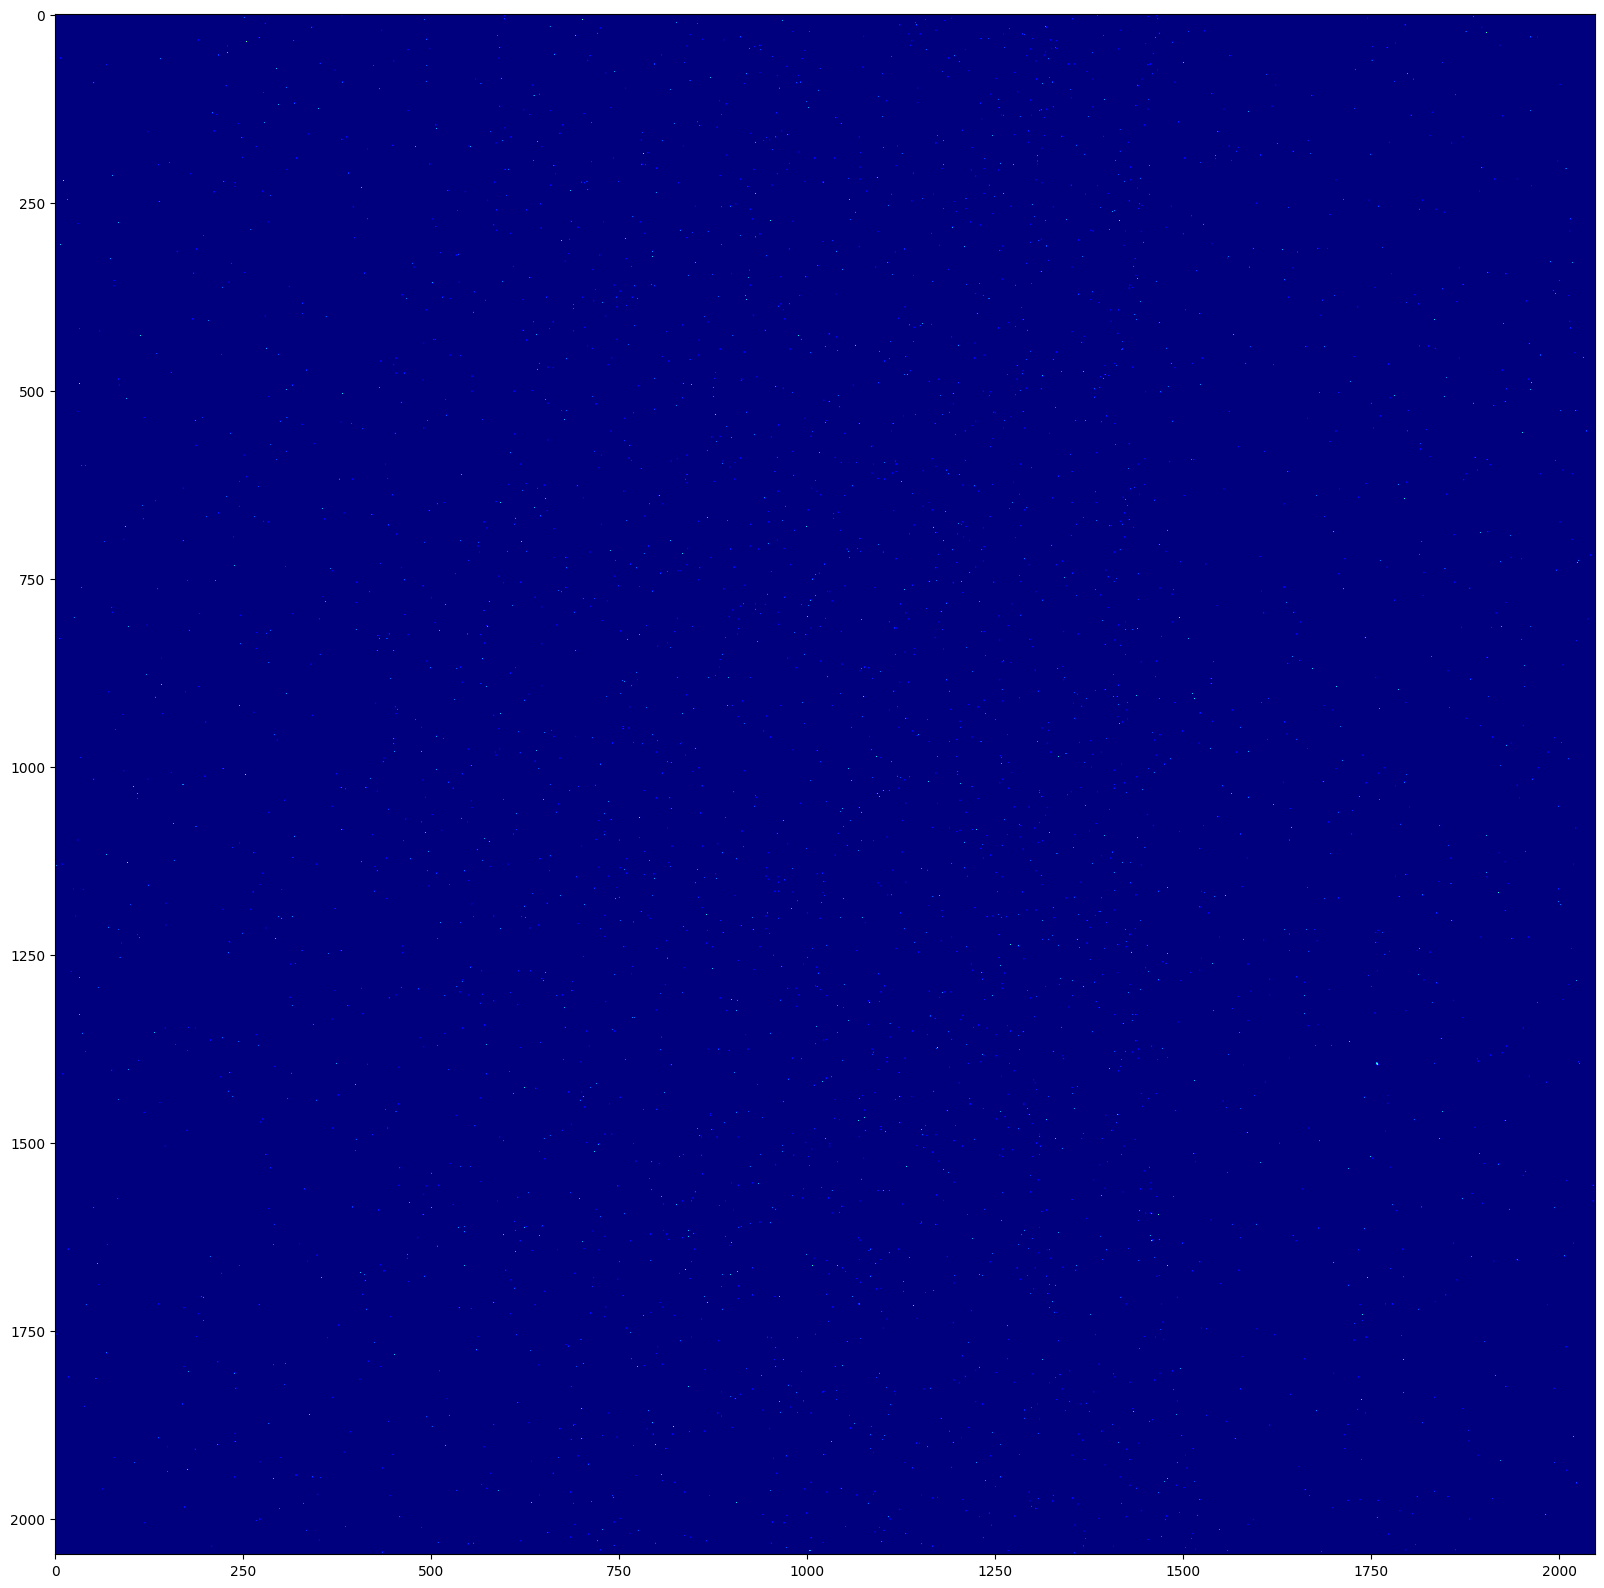

In [81]:
#%matplotlib qt
plt.figure(figsize=(20, 20))
plt.imshow(primary_hits, cmap="jet")

## Spectrum

Let's turn this into a crude spectrum

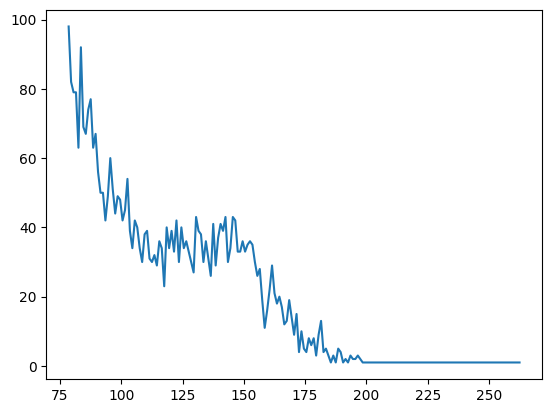

In [82]:
%matplotlib inline
from histograms import make_histogram

n_bins = -1
hist_centres, hist_data = make_histogram(primary_hits, n_bins, xrange=(50,300))
plt.plot(hist_centres[hist_data.nonzero()], hist_data[hist_data.nonzero()])


# Part 2: The second threshold
Every pixel that is not noise, and is not a full on hit, should be from spread photon charge. Since the noise is now centred around 0, we can take the second threshold to be some number of SDs of the noise from 0.

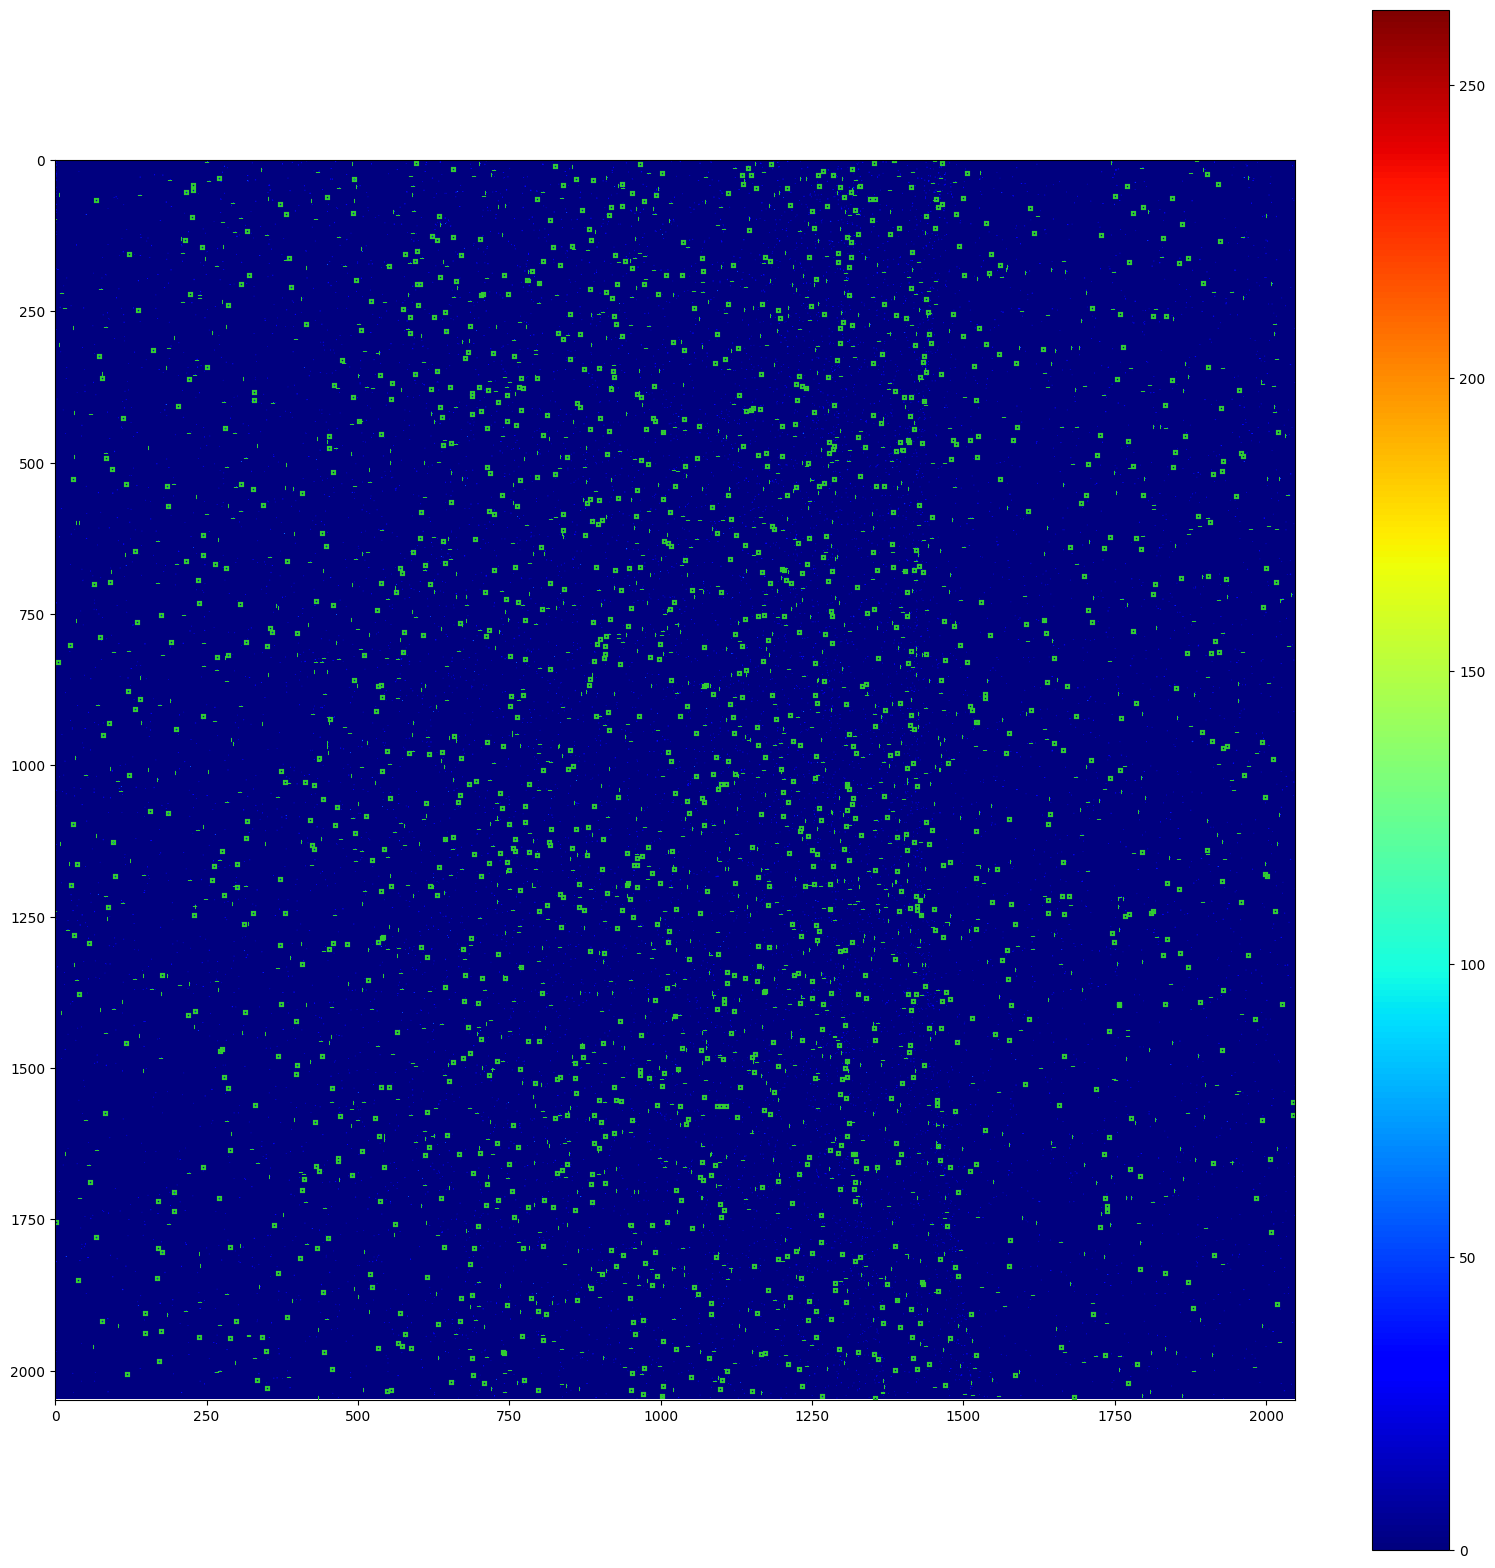

In [83]:
#%matplotlib qt

noise_sd = pedestal_params[2]
second_cutoff = 4 * noise_sd

secondary_hits = np.where(np.logical_and(pedestal_subtracted > second_cutoff, pedestal_subtracted<primary_cutoff), pedestal_subtracted, 0)

plt.figure(figsize=(20, 20))
plt.imshow(secondary_hits+primary_hits, cmap="jet")
plt.colorbar()

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

for cell in np.array(np.nonzero(primary_hits)).transpose():
    highlight_cell(cell[1], cell[0], color="limegreen", linewidth=3)

plt.show()

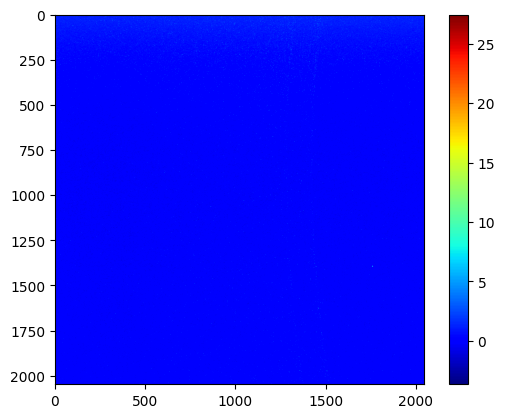

In [84]:
plt.imshow(pedestal_subtracted/noise_sd, cmap="jet")
plt.colorbar()
plt.show()

## Including these pixels

First, we will go through all the primary hits, and search their neighbourhood for secondary hits that likely come from charge spread. These pixels' values can then be added to the central one to get an overall hit intensity.

In [85]:
def secondary_neighbours(loc: tuple[int], secondary_hits: np.ndarray):
    """Takes a location in an image, and returns all directly neighbouring pixels
    that are secondary hits pixels."""
    ns = []

    nrows, ncols = secondary_hits.shape

    if loc[0] != 0:
        ns.append((loc[0] - 1, loc[1]))
    if loc[0] != nrows - 1:
        ns.append((loc[0] + 1, loc[1]))
    if loc[1] != 0:
        ns.append((loc[0], loc[1] - 1))
    if loc[1] != ncols - 1:
        ns.append((loc[0], loc[1] + 1))

    valid = []
    for n in ns:
        if secondary_hits[n]:
            valid.append(n)
    return valid

In [86]:
from hit_detection import bfs
primary_hit_locations = np.array(np.nonzero(primary_hits)).transpose()

def complete_primary_hits(primary_hits, secondary_hits, primary_hit_locations):

    final_hit_values = np.zeros(len(primary_hit_locations))
    used_secondary_hits = np.zeros_like(secondary_hits)

    for i, loc in enumerate(primary_hit_locations):
        loc=tuple(loc)
        secondary_hit_contributions = bfs(loc, secondary_hits, np.zeros_like(secondary_hits))[0]
        final_hit_values[i] += primary_hits[loc]

        for l in secondary_hit_contributions:
            final_hit_values[i] += secondary_hits[l]
            used_secondary_hits[l] = 1
    
    return final_hit_values, used_secondary_hits

def complete_primary_hits_2(img, primary_hit_locations, secondary_hits):

    final_hit_values = np.zeros(len(primary_hit_locations))
    used_secondaries = np.zeros_like(secondary_hits)


    for i, loc in enumerate(primary_hit_locations):
        loc=tuple(loc)
        # get indicies of all non-zero items in secondary_hits that are within 1 pixel of the primary hit
        secondary_neighbours = secondary_hits[max(loc[0]-1,0):min(loc[0]+2, secondary_hits.shape[0]), max(loc[1]-1,0):min(loc[1]+2, secondary_hits.shape[1])]

        secondary_neighbour_locations = np.array(np.nonzero(secondary_neighbours)).transpose()
        secondary_neighbour_locations[:, 0] += loc[0] - 1
        secondary_neighbour_locations[:, 1] += loc[1] - 1

        final_hit_values[i] = np.sum(secondary_neighbours.flatten()) + img[loc]

        for l in secondary_neighbour_locations:
            used_secondaries[tuple(l)] = 1
    
    return final_hit_values, used_secondaries

In [87]:
hit_values, used_secondaries = complete_primary_hits_2(pedestal_subtracted, primary_hit_locations, secondary_hits)

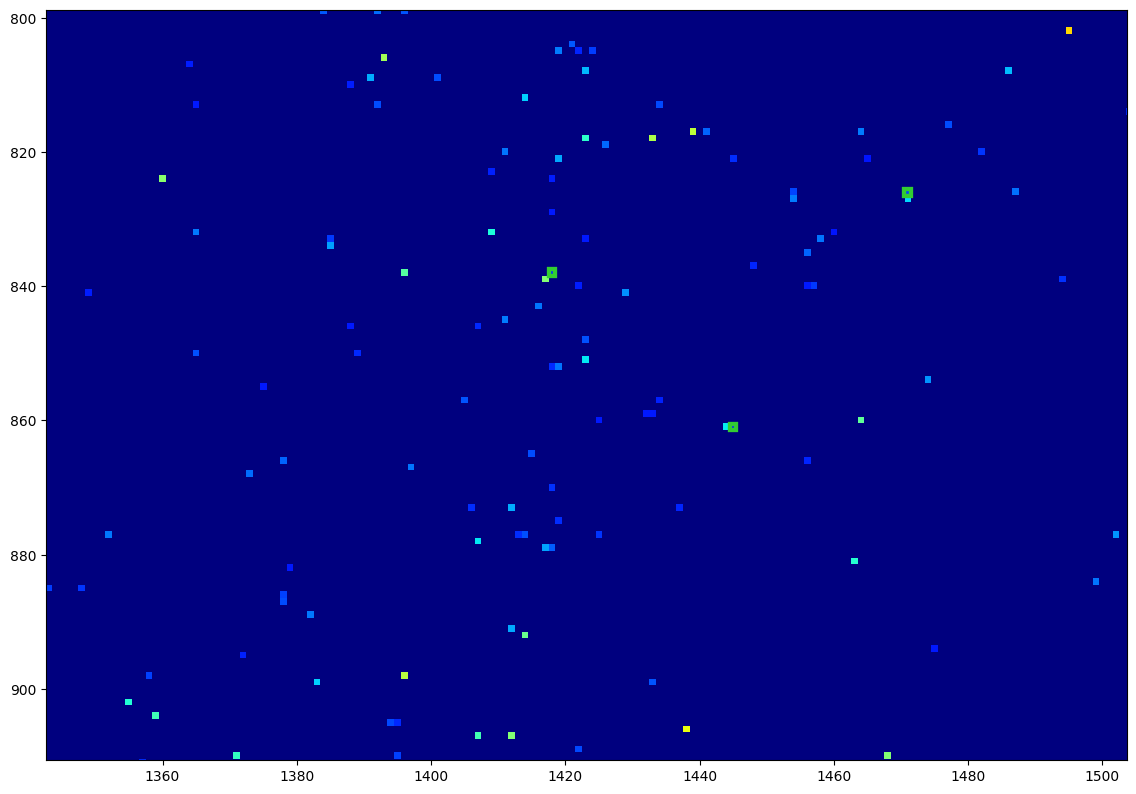

In [91]:
%matplotlib inline
plt.imshow(secondary_hits+primary_hits, cmap="jet")
for loc in np.array(np.nonzero(used_secondaries)).transpose():
    highlight_cell(loc[1], loc[0], color="limegreen", linewidth=3)
plt.show()

In [88]:
hit_values_2 = complete_primary_hits_2(pedestal_subtracted, primary_hit_locations)

TypeError: complete_primary_hits_2() missing 1 required positional argument: 'secondary_hits'

Warning from make_histogram: upper limit of xrange has been set below max value in histogram


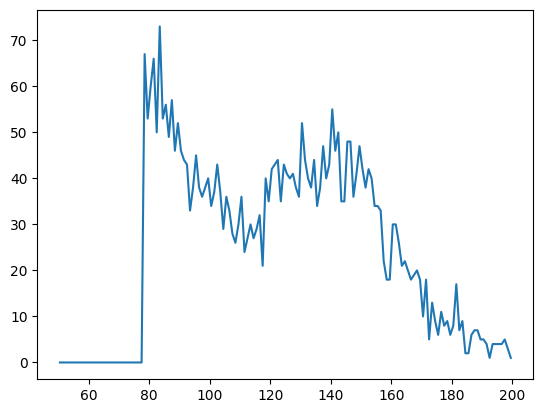

In [ ]:
%matplotlib inline
bin_centres, hist_data = make_histogram(hit_values, -1, xrange=(50,200))

plt.plot(bin_centres, hist_data)

In [107]:
from hit_detection import locate_hits
def get_secondary_hits(secondary_hits, used_secondaries):

    hits = locate_hits(secondary_hits, used_secondaries)
    print(len((secondary_hits-used_secondaries).nonzero()[0]))

    hit_values = []

    for i, hit in enumerate(hits):
        # only count secondary hits that span multiple pixels
        if len(hit) > 1:
            hit_values.append(np.sum([secondary_hits[tuple(l)] for l in hit]))

    
    return np.array(hit_values)

In [108]:
secondary_hit_values = get_secondary_hits(secondary_hits, np.zeros_like(secondary_hits))


12964


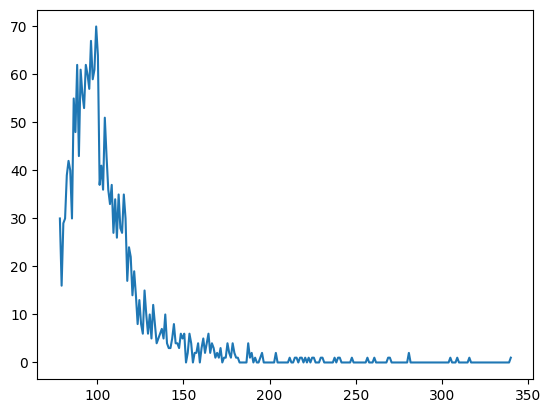

In [112]:
secondary_hist_centres, secondary_hist_data = make_histogram(secondary_hit_values, -1)

plt.plot(secondary_hist_centres, secondary_hist_data)


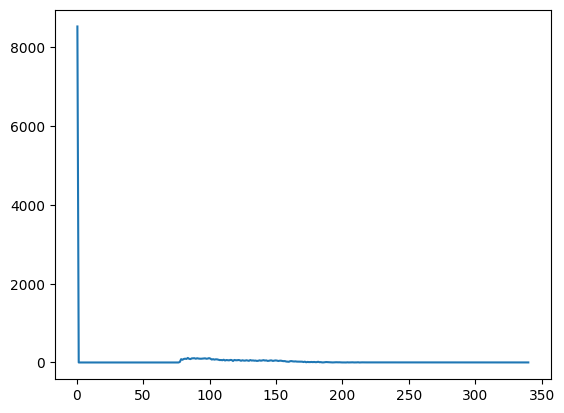

In [103]:
all_hits = np.concatenate((hit_values, secondary_hit_values))

all_hist_centres, all_hist_data = make_histogram(all_hits, -1)

plt.plot(all_hist_centres, all_hist_data)